### Import Required Libraries

In [74]:
import numpy as np
from scipy.integrate import odeint
from scipy.signal import butter, filtfilt, find_peaks
from scipy.stats import gaussian_kde,ecdf
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline,LinearNDInterpolator
from scipy.optimize import fsolve
import time
import pandas as pd
import os

### Viscous_parameters_solver Function

In [75]:
def viscous_parameters_solver(t, theta,mobject):
    l = 0.6505
    r = 0.36115625
    g = 9.7949
    mnet = 2.974+mobject #FIRST NUMBER IS DISK AND SENSOR, NOT INCLUDING TRANSMITTER
    noise_param = 0.04
    # Filter the data
    b, a = butter(4, 0.05, 'low')
    filtered_theta = filtfilt(b, a, theta)
    peak_filtering_param = 3 #remember to adjust as to remove outliers associated with signal noise

    # Use find_peaks with adjusted parameters to identify peaks
    peaks, _ = find_peaks(filtered_theta, prominence=np.deg2rad(noise_param*peak_filtering_param))  # adjust prominence if needed

    # Check if peaks are found
    if len(peaks) == 0:
        print("No peaks were found.")
        return [0, 0, 0, 0]

    # Calculate the periods between peaks
    periods = np.diff(t[peaks])
    # plt.figure()
    # plt.plot(t,theta,'kx',ms=1)
    # plt.plot(t,filtered_theta,'r-')
    # plt.xlim((0,15))
    # plt.show()
    # plt.figure()
    # plt.plot(periods)
    # plt.show()
    # Calculate median filtered period
    T_d = np.median(periods)
    # print(f"T_d = {T_d}", end='\n')
    omega_d = (2 * np.pi) / T_d
    # print(f"Calculated wd = {omega_d}", end='\n')

    # Calculate the damping ratio
    amplitude_ratios = filtered_theta[peaks][1:] / filtered_theta[peaks][:-1]
    damping_ratios = -1*np.log(amplitude_ratios)
    # print(f"Calculated dr = {np.median(damping_ratios)}",end='\n')
    zeta = np.median(damping_ratios) / ( np.sqrt( (4 * np.pi ** 2) + (np.median(damping_ratios) ** 2) ) )
    # print(f"Calculated zeta = {zeta}",end='\n')

    # Calculate natural frequency and inertia
    omega_n = omega_d / np.sqrt(1 - zeta ** 2)
    Inet_pure = (mnet * g * r ** 2) / (l * omega_n ** 2)
    c_pure = zeta * 2 * np.sqrt(Inet_pure * ((mnet * g * r ** 2) / l))

    return [Inet_pure, (mnet * g * r ** 2) / l, c_pure, 0]


#### Calculating Disk Inertia, Known Inertia Values

In [76]:
# # Importing Disk Data
folder_path = '/home/coder/workspace/Finnamore/I_2C'
disk_path = '/home/coder/workspace/Finnamore/I_D'
numTests = 44
df_disk_data = {}
disk_inertia_data = np.zeros(numTests)
disk_period_data = np.zeros(numTests)

# Importing and Calculating Disk Inertial Data
for i in range(numTests):
    # File Path Creation
    file_name = 'I_D_{:02}.csv'.format(i)
    file_path = os.path.join(disk_path,file_name)

    #Reading in Data
    df = pd.read_csv(file_path,usecols=[0,1])
    df_disk_data[i] = df.values

    #Converting from Miliseconds to Seconds
    df_disk_data[i][:,0] = np.divide(df_disk_data[i][:,0],1000)

    #Solving for Disk Inertia
    disk_inertia_data[i] = viscous_parameters_solver(df_disk_data[i][:,0],df_disk_data[i][:,1],0)[0]

#Setting up Dicitonary of Known Inertial Values
disk_inertia = np.median(disk_inertia_data)
disk_period = np.median(disk_period_data)
I_names = ['11','10','09','08','7','6','5','4','3','2','1']
# disk_inertia = 0.2035
m_single_weight = .4465
I_single_cylinder = 0.5*m_single_weight*(0.0254**2)
# Calculating and Storing Known Inertial Values

actual_inertias = {}
for name in I_names:
    actual_inertias[name] = (I_single_cylinder+(m_single_weight*((0.0254*(int(name)+1))**2)))


### Import Data


In [79]:
raw_data = {}
inertia_data = {}
numSlices=10
# Define the pattern or names of your CSV files

# Iterating over all the effective frequencies
for downsample in range(numSlices):
    inertia_data[downsample]={}

    # iterating over all the different inertia values measured
    for name in I_names:
        raw_data[name] = {}
        inertia_data[downsample][name] = np.zeros(numTests)

        # iterating over all the individual tests
        for i in range(numTests):

            # writing file name
            file_name = ('I_2C_{}'.format(name))+'_{:02}.csv'.format(i)
            file_path = os.path.join(folder_path, file_name)

            # reading in the data
            df = pd.read_csv(file_path, usecols=[0, 1])
            raw_data[name][i] = df.values

            # converting to seconds from miliseconds
            raw_data[name][i][:,0] = np.divide(raw_data[name][i][:,0],1000)

            # downsampling
            t = raw_data[name][i][:,0][::downsample+1]
            theta = raw_data[name][i][:,1][::downsample+1]

            # solving for inertia with downsampled data
            inertia_data[downsample][name][i] = viscous_parameters_solver(t,theta,2*m_single_weight)[0] - disk_inertia

#### Plot/Print Results

/tmp/ipykernel_90485/3575541085.py:33: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter(effectiveFrequency[name],measuredInertias[name],c=colors[name],s=2,label='Inertia Data from Test {}'.format(name))


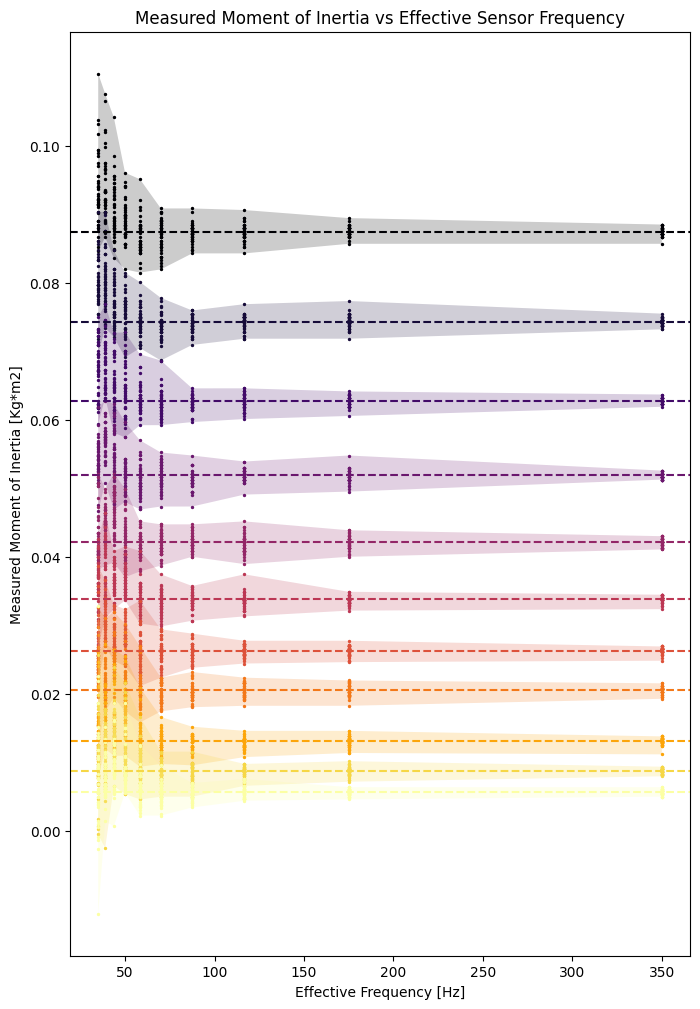

In [80]:
measuredInertias = {}
effectiveFrequency = {}
meanInertias = {}
mins = {}
maxes = {}
eff_freq = {}
for name in I_names:
    measuredInertias[name] = np.array([])
    effectiveFrequency[name] = np.array([])
    meanInertias[name] = np.mean(inertia_data[0][name])
    mins[name] = np.zeros(numSlices)
    maxes[name] = np.zeros(numSlices)
    eff_freq[name] = np.zeros(numSlices)
    for downsample in range(numSlices):
        measuredInertias[name] = np.concatenate((measuredInertias[name],inertia_data[downsample][name]))
        effectiveFrequency[name] = np.concatenate((effectiveFrequency[name],np.ones(numTests)*(350/(downsample+1))))
        mins[name][downsample] = np.min(inertia_data[downsample][name])
        maxes[name][downsample] = np.max(inertia_data[downsample][name])
        eff_freq[name][downsample] = (350/(downsample+1))

colors = {}
cmap = mpl.colormaps['inferno']
deez = np.linspace(0,11,len(I_names))/len(I_names)
count = 0
for name in I_names:
    colors[name] = cmap(deez[count])
    count=count+1
    

plt.figure(figsize=(8,12))
plt.style.use('default')
for name in I_names:
    plt.scatter(effectiveFrequency[name],measuredInertias[name],c=colors[name],s=2,label='Inertia Data from Test {}'.format(name))
    plt.axhline(y=meanInertias[name],linestyle='--',c=colors[name])
    plt.fill_between(eff_freq[name],mins[name],maxes[name],color=colors[name],alpha=0.2,edgecolor='none')


plt.xlabel('Effective Frequency [Hz]')
plt.ylabel('Measured Moment of Inertia [Kg*m2]')
plt.title('Measured Moment of Inertia vs Effective Sensor Frequency')
plt.show()


### Plot/Print Results